# Discretisation with Decision Trees

Discretisation with Decision Trees consists in using a decision tree to identify the optimal bins. When a decision tree makes a decision, it assigns an observation to one of n end leaves. Therefore, any decision tree will generate a discrete output, which values are the predictions at each of its n leaves.

How to do discretisation with trees?

- 1. Train a decision tree of limited depth (2, 3 or 4) using the variable we want to discretise and the target.
- 2. Replace the values by the output returned by the tree.

**Advantages**

- The output returned by the decision tree is monotonically related to the target.
- The tree end nodes, or bins in the discretised variable show decreased entropy: that is, the observations within each bin are more similar among themselves than to those of other bins.

**Limitations**

- Prone over-fitting
- More importantly, some tuning of the tree parameters needed to obtain the optimal number of splits (e.g., tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('data/titanic.csv',
                   usecols = ['age', 'fare', 'survived'])


data.head()

,survived,age,fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [5]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

In [6]:
X_train.head()

,age,fare
857,51.0,26.5500
52,49.0,76.7292
386,1.0,46.9000
124,54.0,77.2875
578,16.0,14.4583


In [7]:
# example: build Classification tree using Age to predict Survived

tree_model = DecisionTreeClassifier(max_depth=3)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:,1]

X_train.head(10)

,age,fare,Age_tree
857,51.0,26.5500,0.465517
52,49.0,76.7292,0.465517
386,1.0,46.9000,0.411765
124,54.0,77.2875,0.465517
578,16.0,14.4583,0.366337
549,8.0,36.7500,0.642857
118,24.0,247.5208,0.366337
12,20.0,8.0500,0.366337
157,30.0,8.0500,0.366337
127,24.0,7.1417,0.366337


In [8]:
tree_model.predict_proba(X_train['age'].to_frame()).shape

(623, 2)

In [9]:

# let's explore how many end points the tree created

X_train['Age_tree'].unique()

array([0.46551724, 0.41176471, 0.36633663, 0.64285714, 0.        ,
       1.        , 0.5       ])

Text(0, 0.5, 'Survived')

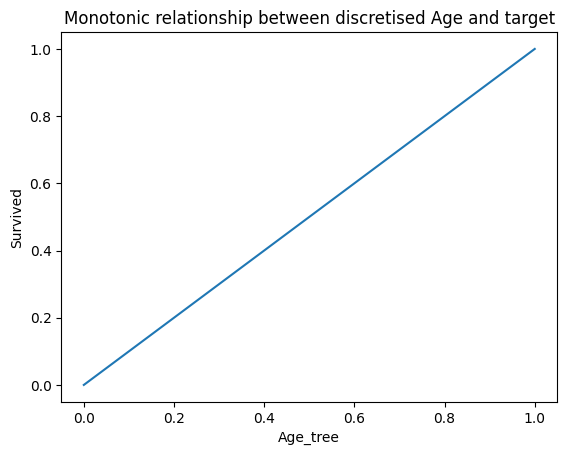

In [10]:

# monotonic relationship with target

pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<AxesSubplot: xlabel='Age_tree'>

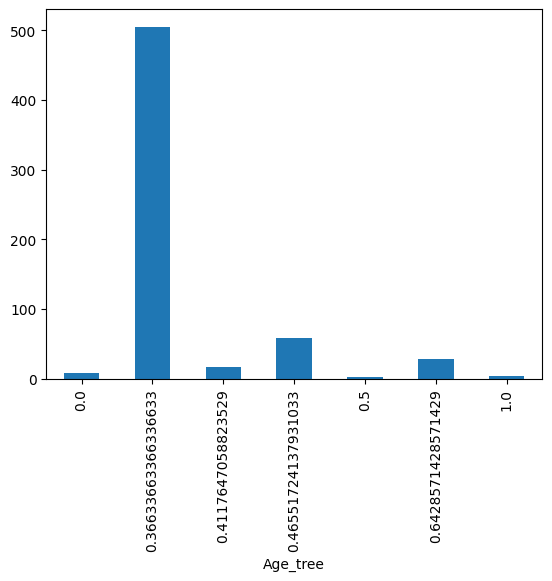

In [11]:
# number of passengers per probabilistic bucket / bin

X_train.groupby(['Age_tree'])['age'].count().plot.bar()

<AxesSubplot: xlabel='Age_tree'>

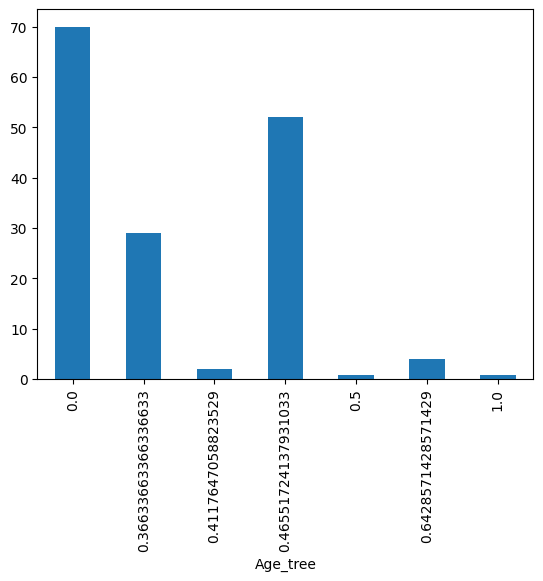

In [12]:
# median age within each bucket originated by the tree

X_train.groupby(['Age_tree'])['age'].median().plot.bar()

In [13]:
# let's see the Age limits buckets generated by the tree
# by capturing the minimum and maximum age per each probability bucket, 
# we get an idea of the bucket cut-offs

pd.concat( [X_train.groupby(['Age_tree'])['age'].min(),
            X_train.groupby(['Age_tree'])['age'].max()], axis=1)

,age,age
Age_tree,,
0.000000,64.00,74.00
0.366337,9.00,47.00
0.411765,0.92,2.00
0.465517,48.00,63.00
0.500000,0.67,0.67
0.642857,3.00,8.00
1.000000,0.75,80.00


Thus, the decision tree generated the buckets: 65-74, 9-44, 45-64 and 0.7-8 and 0-16-0.16, with probabilities of survival of .0, .36, .45, .52 and .1 respectively.

## Tree visualisation

In [14]:
# we can go ahead and visualise the tree by saving the model to a file,
# and opening that file in the below indicated link

with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

# go here to open the file: http://webgraphviz.com

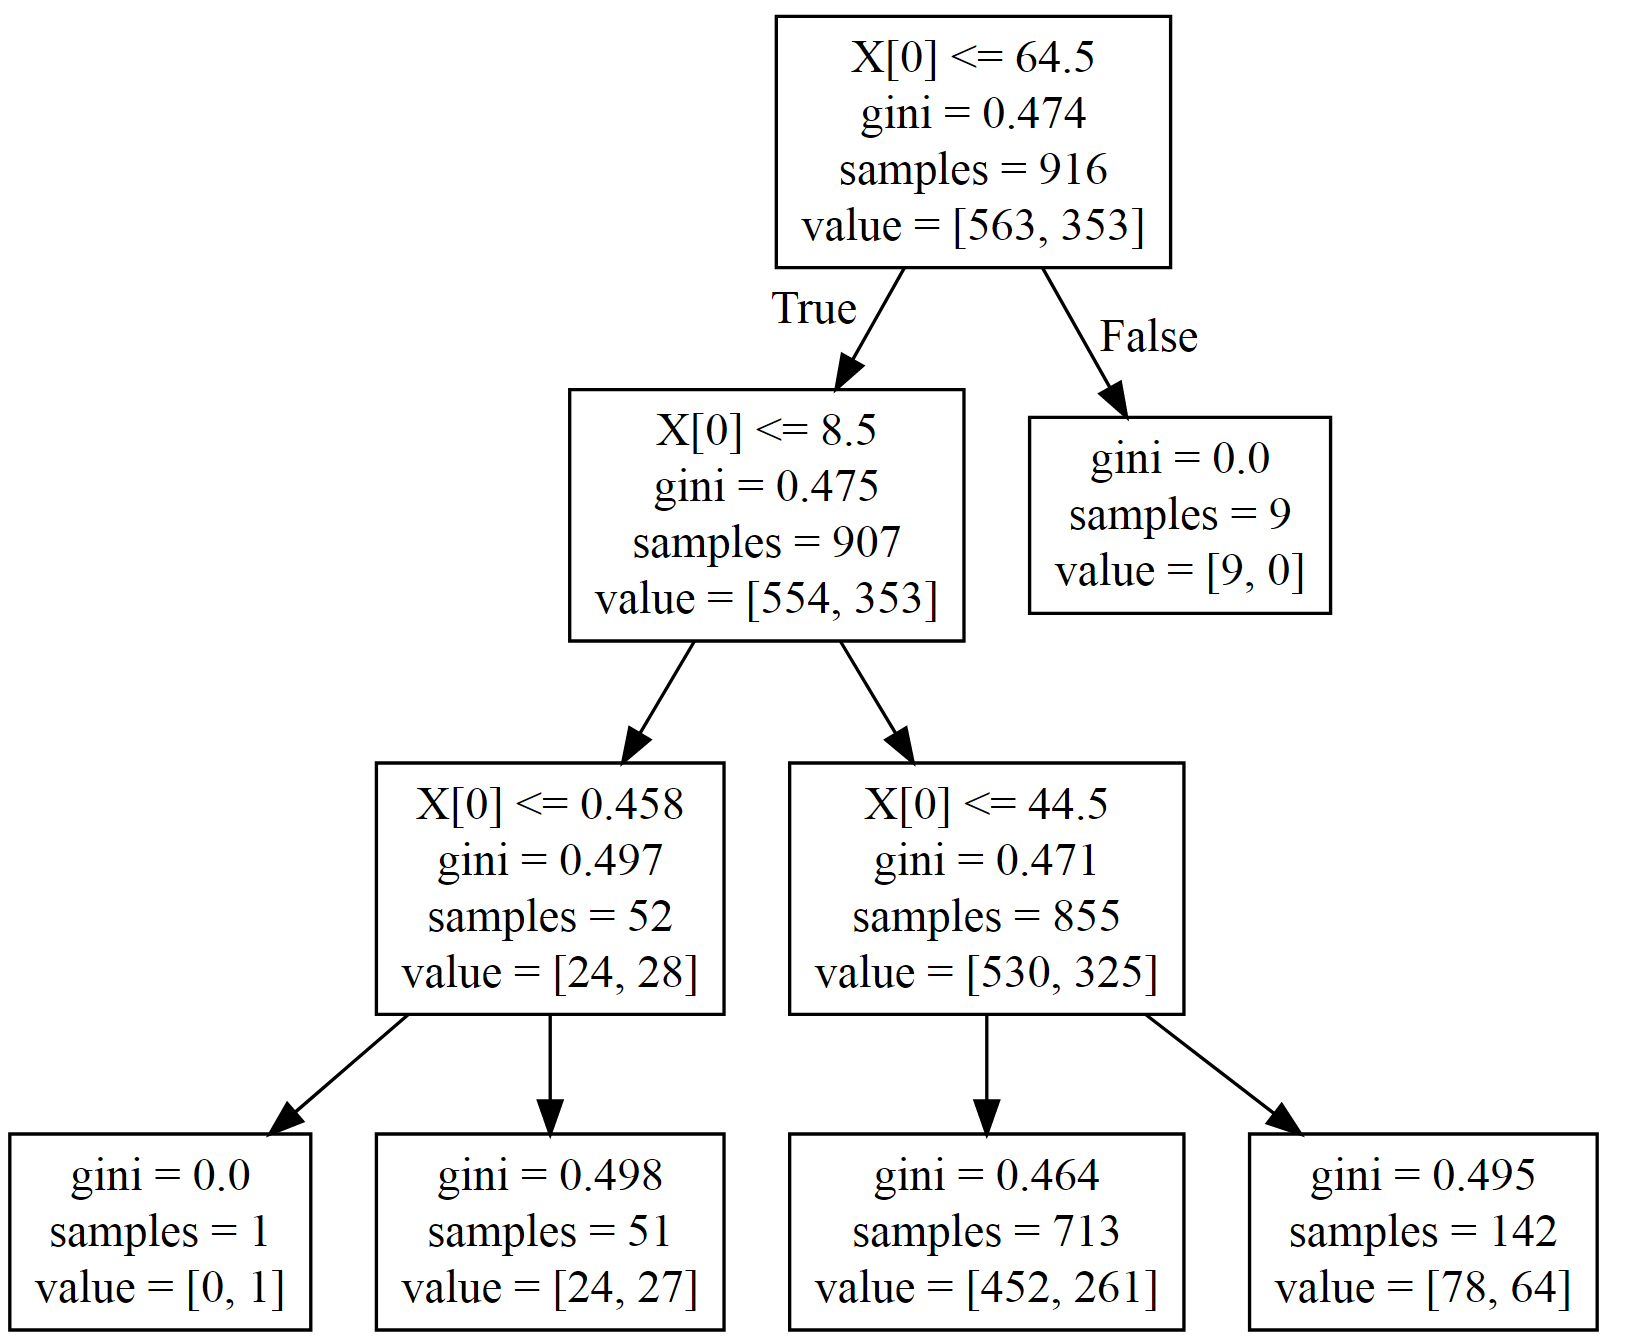

In [19]:
# this is what you should see if you do what is described in the previous cell

# I saved the image you should retrieve in the server above into a png, and then load
# it here to smooth the demo

# the  plot indicates  the age cut-offs at each node, and also the number of samples at each node, and 
# the gini

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename =PATH , width=1000, height=1000)

# THis tree below is not exactly what we got but sample tree to for understanding

**Let's expand the tree results to the test set, and explore the monotonic relationship**

Text(0, 0.5, 'Survived')

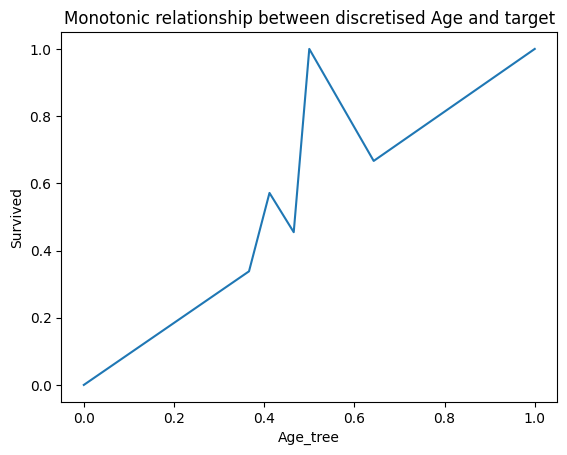

In [20]:
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# monotonic relationship with target

pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

We can see that the monotonic relationship is not maintained in the test set, which probably indicates that the tree we build was over-fitting to the train set.

# Building the optimal decision tree
There are a number of parameters that we could optimise to obtain the best bin split using decision trees.

I will optimise the tree depth for this demonstration. But remember that we could also optimise the remaining parameters of the decision tree.

In [21]:
# Build trees of different depths, and calculate the roc-auc of each tree
# choose the depth that generates the best roc-auc

score_ls = []  # here we store the roc auc
score_std_ls = []  # here we store the standard deviation of the roc_auc

for tree_depth in [1, 2, 3, 4]:

    # call the model
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)

    # train the model using 3 fold cross validation

    scores = cross_val_score(
        tree_model, X_train['age'].to_frame(), y_train, cv=3, scoring='roc_auc')
    
    # save the parameters
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

    
# capture the parameters in a dataframe
temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(
    score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.525278,0.010202
1,2,0.519110,0.007473
2,3,0.517070,0.008169
3,4,0.531766,0.025732


##We obtain the best roc-auc using depths of 2 (same value as depth 4 but smaller std). I will select depth of 2 to proceed.



## Transform the feature using tree

In [22]:
tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:, 1]
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:, 1]

Text(0, 0.5, 'Survived')

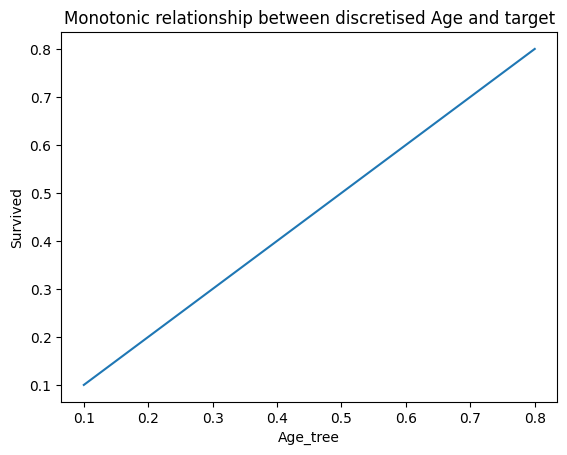

In [23]:
# monotonic relationship with target in train set

pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

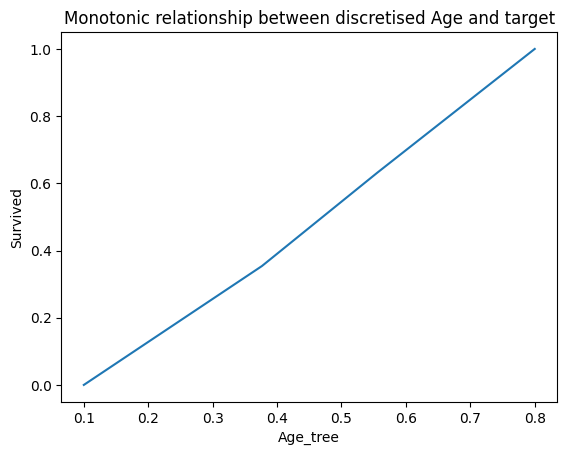

In [24]:
# and in the test set

X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# monotonic relationship with target
pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<AxesSubplot: xlabel='Age_tree'>

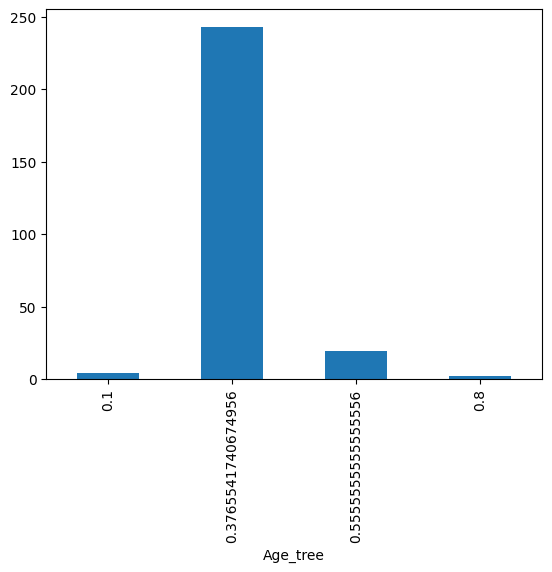

In [25]:
# median age within each bucket originated by the tree

X_test.groupby(['Age_tree'])['age'].count().plot.bar()

We could try and optimise the decision tree further to see if we can keep the monotonic relationship. Or alternatively, directly test the model performance with these engineered features and see if they add any value.

# Discretisation with Decision Trees using Feature - Engine

**Discretisation with Decision Trees using Feature-Engine**

feature Engine allows you to implement decision tree discretisation on all your numerical variables very easily, including search over the multiple parameters of the decision tree, to find the best one.



In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import DecisionTreeDiscretiser

In [29]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('data/titanic.csv',
                   usecols = ['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [30]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [31]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

In [32]:
X_train.head()

,age,fare
857,51.0,26.5500
52,49.0,76.7292
386,1.0,46.9000
124,54.0,77.2875
578,16.0,14.4583


In [33]:
# set up the decision tree discretiser indicating:
# cross-validation number (cv)
# how to evaluate model performance (scoring)
# the variables we want to discretise (variables)
# whether it is a target for regression or classification
# and the grid with the parameters we want to test

treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['age', 'fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        regression=False, scoring='accuracy',
                        variables=['age', 'fare'])

In [34]:
# we can inspect the tree for age
treeDisc.binner_dict_['age'].best_params_

{'max_depth': 1, 'min_samples_leaf': 10}

In [35]:
# and the performance obtained on the train set while fitting

treeDisc.scores_dict_['age']

0.6243980738362761

In [36]:
# and the best parameters for fare
treeDisc.binner_dict_['fare'].best_params_

{'max_depth': 2, 'min_samples_leaf': 10}

In [37]:
# and the performance obtained on the train set while fitting

treeDisc.scores_dict_['fare']

0.6645264847512039

By comparing the accuracy of the decision trees for age and fare, we can derive that fare is a better indicator of the outcome survived.



In [38]:
# let's transform the data

train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [39]:
# let's inspect how many bins we found

train_t['age'].unique()

array([0.37172775, 0.58      ])

Text(0, 0.5, 'Survived')

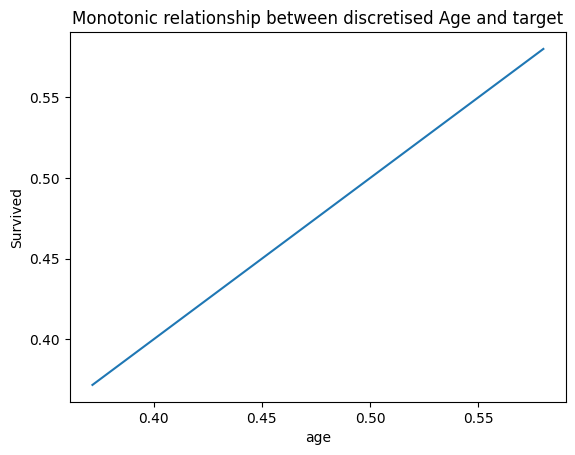

In [40]:
# monotonic relationship with target: train set

pd.concat([train_t, y_train], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

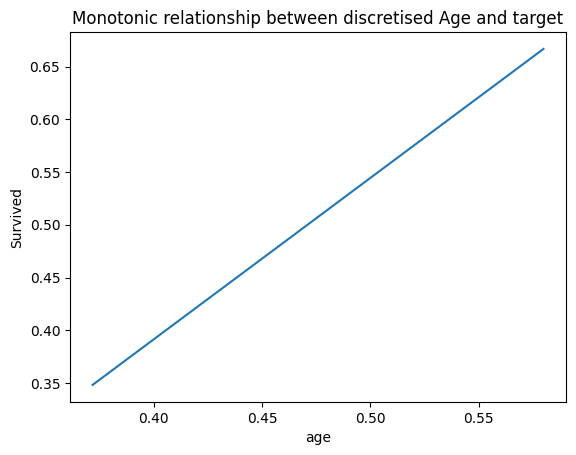

In [41]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

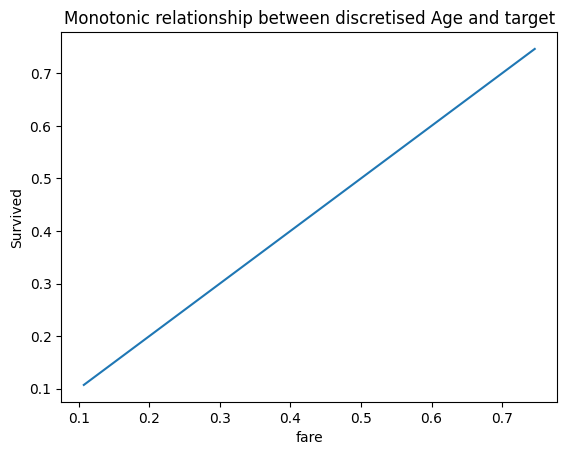

In [42]:
# let's explore the monotonic relationship for fare
pd.concat([train_t, y_train], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

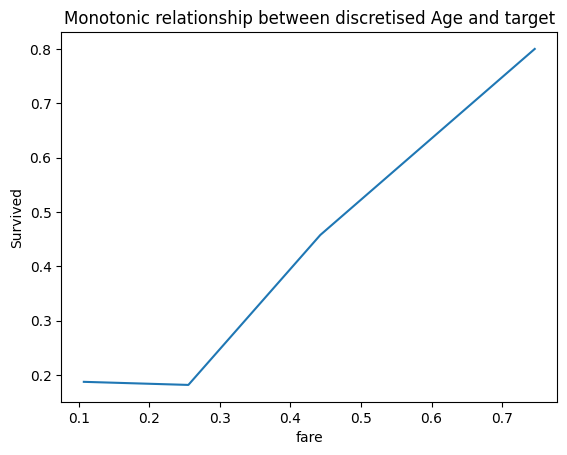

In [43]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Number of observations per bin')

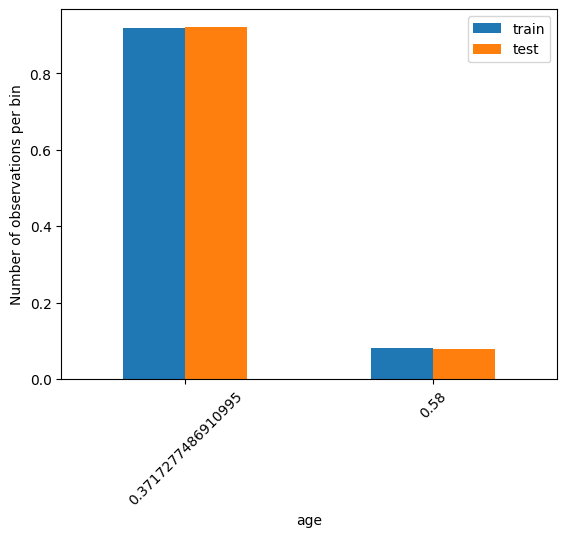

In [44]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

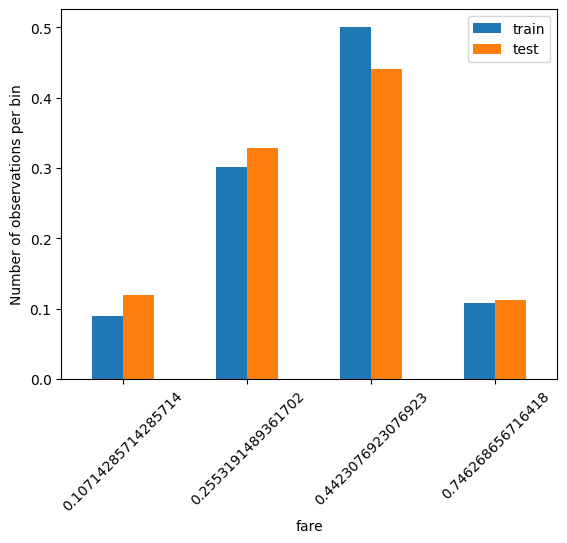

In [45]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')